# Addressing the Ill-Posed Inverse Problem 
This tutorial picks up following the "Freyberg pilot points" tutorial in which we added a lot more adjustable parameters. We saw that this allowed us to get an excellent fit with measured data (too good!) but resulted in unrealistic parameter fields. Not to mention that we still underepresented forecast uncertainty.

## Regularization

We have more unkown parameters than observations. Thus, we have an ill-posed inverse problem. The mathematical term for the process through which a unique solution is sought for a nonunique inverse problem is “regularization”. The goal of regularised inversion is to seek a unique parameter field that results in a suitable fit between model outputs and field measurements, whilst minimizing the potential for wrongness in model predictions. That is, out of all the ways to fit a calibration dataset, regularized inversion seeks the parameter set of minimum error variance.

There are two main approaches used to stabilize this problem: 
 1) adding soft knowledge and/or 
 2) reducing the problem dimensionality. 

These methods can be used by themselves, but are most commonly applied together.


## 1. Tikhonov Regularization
We have moved up the simplicity-complexity curve because now we have many more parameters, even more than our observations.  But have we passed the sweetspot? One way to seek a parameter field of minimum error variance is to seek a parameter field that allows the model to fit the calibration dataset, but whose values are also as close as possible to a set of “preferred parameter values”.

<img src="intro_to_regularization\Hunt1998_sweetspot.png" style="float: center">

Again, it is not simply the number of parameters that is at issue.  The better way to think of it is that we just want to avoid "living beyond our means". That is, we do not bring more parameters to bear than we have the ability to constrain.  We constrain them observations as we have seen so far, but we also know things about the system that are not hard data like measurements.  This "soft-knowledge" can also be applied to  constrain our parameters through a mechanism called __"Tikhonov regularization"__.  In this formulation of the inverse problem, we add a second term to our "best fit" metric Phi. This second term reflects the deviation from our soft-knowledge of the system, and is a penalty to our fit. Here's how it looks using the Anderson et al. (2015) formulation:

<img src="intro_to_regularization\tik-reg_eq9.8.png" style="float: center">

As first term after the equal sign is our __measurement objective function__, which we've been working with all week.  The last term on the right is called the __"regularization objective function"__. These 2 terms combine to create a __total Phi__ on the left.  __Now Total Phi is what we minimize__, which means we are minimizing our observed-to-simulated residuals __AND__ the deviation from soft-knowledge.  So in this way Tikhonov regularization is a "dual-constrained minimization".  

Andrey Tikhonov
<img src="intro_to_regularization\Andrey_Tikhonov_picture.jpeg" style="float: center">

Anderson et al. (2015) looks a little closer at this in equation 9.9:


<img src="intro_to_regularization\tik-reg_eq9.9.png" style="float: center">

The first term to the right of the equals sign is the measurement objective function from
Eqn (9.6), which is calculated as the sum of squared weighted residuals, where *n* residuals,
*ri*, are calculated from hard knowledge and wi are their respective weights. The second
term quantifies the penalty resulting from deviations from soft knowledge as the sum
of *q* deviations from *j* soft knowledge conditions *fj*, where *fj* is a function of model parameters
*p*. A calibrated model, therefore, is found by minimizing both the measurement
objective function (hard data) and the soft knowledge penalty.

> __Take-home point #1 from these equations:__
> When Tikhonov is set up correctly, PEST should only deviate from the preferred condition when there is a > suffient improvement in our fit to the observations (= the measurement objective function).  
>
> __Take-home point #2 from these equations:__  
> The two contributors to our total $Phi$ are __*carried separately in the parameter estimation*__.  
>
This is important. It allows us to control the balance between fitting measured data and respecting expert knowledge. This is how we avoid __overfitting__.


### Prior Information

How do we express soft-knowledge quantiatively so we can minimize it?

PEST(++) provides a user with a great deal of flexibility in how Tikhonov constraints can be introduced to an inversion process. The easiest way is to do this is through the use of prior information equations. When prior information equations are employed, Tikhonov constraints are expressed through preferred values that are assigned to linear relationships between parameters. (Equality is the simplest type of linear relationship.) Weights must be assigned to these equations. As is described in PEST documentation, when PEST is run in “regularization” mode, it makes internal adjustments to the weights that are assigned to any observations or prior information equations that belong to special observation groups that are referred to as “regularization groups”. 

We add preferred conditions.  These are typically:

1. *preferred  value* - "I believe this Kh parameter is around 1 m/d"
2. *preferred difference* - "I believe  this area has a Kh 10 m/d higher than that area" 

One of the most useful preferred condition for collapsing all these parameters to fewer bins is a special case of preferred difference where the difference = 0.  This is often called: __"preferred homogeneity"__ -  which equates to something along the lines of "I believe this area has homogeneous Kh" 

Of these, __preferred value__ is the easiest implement, and least memory intensive, preferred condition.   `pyemu` implements this with functionality called "*__zero_order_tikhonov__*". (Mmake sure the initial values in the control file represent your soft-knowledge!) `pyemu` also has preferred difference available - look for *"__first_order_pearson_tikhonov__"*.  We'll see both of these in this notebook. We will demosntrate these functions further on.

### Pilot point regularization can be propogated to other pilot points, or not.

Here are two examples from Anderson et al. (2015).  For "preferred value" __(below (a), left)__ there is no cross-talk between pilot points.  The initial parameter value of each pilot point is the preferred value.  For preferred difference __(below (a), right)__, there is a radius of influence that connects the pilot point regularization (think correlation length from geostatistics).  


<img src="intro_to_regularization\Fig9.15a_Muffles_pp.png" style="float: center">











### Likewise, pilot-point regularization can also be grouped or limited to specific areas.  

For example, if the geology of a site suggests distinct units you can only apply the preferred difference to just the zone:

<img src="intro_to_regularization\Fig9.15b_Kyle_Larry_pp.png" style="float: center">


Here's the caption from Anderson et al. (2015) for posterity:  Figure 9.15 Pilot Points. (a) Network of pilot points in a watershed-scale groundwater flow model (left); linkages between pilot points (right) used to calculate Tikhonov regularization constraints for preferred homogeneity (modified from Muffels, 2008). (b) Network of pilot points used to represent two hydraulic conductivity zones where Tikhonov regularization is applied to pilot points within the same zone (modified from Davis and Putnam, 2013).

### But there is more to think about:

Just like our observations, our preferred conditions are given a weight.  Typically it is uniform (usually 1) - this is what the PEST utility *addreg1.exe* does. On top of this, typically we have the regularization objective function set up to adjust the weights of the different parameter groups during the course of the parameter estimation (IREGADJ variable = 1 in the PEST control file).  See pages 17, 20, and page 34 of SIR 2010-5169. 

__But this is critical__ - these typically end up having somewhat subtle effects; the final say in trade-off between the measurement objective function and the regularization objective function is in a *user specified variable* in the PEST control file called:

### PHIMLIM

Many people missed the importance of this variable in the original Doherty (2003) paper that first showed PEST's pilot points and Tikhonov capabilities. This missed importance was addressed in detail in Fienen et al. (2009).  So, for you to do good modeling with these approaches it is critically important that you take this away, so we will state it again in bigger font:  

The final say in trade-off between the measurement objective function and the regularization objective function is in a *user specified variable* in the PEST control file called:

### PHIMLIM

PHIMLIM is the "Target Measurement Objective Function", which means rather than finding the best fit to the observations, PEST will hit this new PHIMLIM level and  *then find the minimum of the regularization objective function* (find the parameters that most closely match the preferred conditions while still keeping the PHIMLIM target measurement objective function). 

A good way to think of this is that PHIMLIM controls the trade-off between the two parts of the righthand side of the equal sign in equation 9.8 above. We can plot this tradeoff as a Pareto front between adhereing to soft-knowledge (regularization objective function) and getting a better fit (measurement objective function). That looks like:


<img src="intro_to_regularization\Fig9.17_fit_vs_softknowledge_Pareto.png" style="float: center">


A __key point__ is that many points on this curve could be considered a "calibrated model", which equals good fit and reasonable parameters. Which of these we choose is based on professional judgement.  

#### Final point:  
Here's how PHIMLIM expresses itself on the optimal parameters:

<img src="intro_to_regularization\Fig9.16_PHIMLIM.png" style="float: center">

So setting PHIMLIM is our primary way to control the degree of fitting, and keep us from *overfitting*.

The suggested workflow is to:

1) Set PHIMLIM very low (e.g., 1.0) and run the parameter estimation.  This throws away the soft-knowledge and finds the best fit to the observations (minimizes the measurement objective function).  

2) Set PHIMLIM to something like __10% higher__ than this lowest Phi.  Re-run the parameter estimation, evaluate if the parameters are too extreme.  If they are, raise PHIMLIM again.

We'll use this workflow on our pilot point version of Freyberg later.  But first, let's talk a little more about the theory and implementation of ``prior_information`` in the PEST datasets.

## 2. Singular Value Decompostion

 > See the "intro to svd" notebook for an introduction to Singular Value Decompostion.

Tikhonov regularisation adds information to the calibration process in order to achieve numerical stability. In contrast, subspace methods achive numerical stability by reducing the dimensionality of the problem, removing and/or combining prameters. When employing SVD in calibration, only parameters and linear combinations of parameters that are suficiently constrained by measured data are estimated. These parameters are said to reside in the *solution space*. Choosing which parameter combinations to estimate is accomplished via singular value decomposition (SVD). SVD-based parameter estimation fixes intial values for parameters/parameter combinations that are not estimable (reside in the *null space*) and does not adjust them during inversion. (So make sure initial parameter values are sensible!)  

Unlike PEST and PEST_HP, by default, members of the PEST++ suite employ singular value decomposition (or methods closely related to it) for solution of the inverse problem. Unless otherwise specifed, default options are employed. PEST++GLM offers two numerical libraries for implementing SVD; the default option will usually suffice (see the PEST++ user manual for details).

# Admin
Load the Freyberg model and setup up the PEST control file. The next two cells construct the same setups employed during previous tutorials on pilot points.

In [1]:
import sys
import os
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt;
import psutil
import shutil

sys.path.insert(0,os.path.join("..", "..", "dependencies"))
import pyemu
import flopy
assert "dependencies" in flopy.__file__
assert "dependencies" in pyemu.__file__
sys.path.insert(0,"..")
import herebedragons as hbd

plt.rcParams['font.size'] = 10
pyemu.plot_utils.font =10

In [2]:
# folder containing original model files
org_d = os.path.join('..', '..', 'models', 'monthly_model_files_1lyr_newstress')
# a dir to hold a copy of the org model files
tmp_d = os.path.join('freyberg_mf6')
if os.path.exists(tmp_d):
    shutil.rmtree(tmp_d)
shutil.copytree(org_d,tmp_d)
# get executables
hbd.prep_bins(tmp_d)
# get dependency folders
hbd.prep_deps(tmp_d)
# run our convenience functions to prepare the PEST and model folder
hbd.prep_pest(tmp_d)
# convenience function that builds a new control file with pilot point parameters for hk
hbd.add_ppoints(tmp_d)

ins file for heads.csv prepared.
ins file for sfr.csv prepared.
noptmax:0, npar_adj:1, nnz_obs:24
written pest control file: freyberg_mf6\freyberg.pst
   could not remove start_datetime
1 pars added from template file .\freyberg6.sfr_perioddata_1.txt.tpl
6 pars added from template file .\freyberg6.wel_stress_period_data_10.txt.tpl
0 pars added from template file .\freyberg6.wel_stress_period_data_11.txt.tpl
0 pars added from template file .\freyberg6.wel_stress_period_data_12.txt.tpl
0 pars added from template file .\freyberg6.wel_stress_period_data_2.txt.tpl
0 pars added from template file .\freyberg6.wel_stress_period_data_3.txt.tpl
0 pars added from template file .\freyberg6.wel_stress_period_data_4.txt.tpl
0 pars added from template file .\freyberg6.wel_stress_period_data_5.txt.tpl
0 pars added from template file .\freyberg6.wel_stress_period_data_6.txt.tpl
0 pars added from template file .\freyberg6.wel_stress_period_data_7.txt.tpl
0 pars added from template file .\freyberg6.wel_s

### Tikhnov regularization as "prior information".  

In pyemu, we can add two forms of regularization:
- preferred __value__: we want the parameter values to stay as close to the initial values as possible
- preferred __difference__: we prefer the differences in parameter values to be minimized

Preferred value is easy to understand, we simply add ``prior_information`` to the control file to enforce this condition.  `pyemu` uses a helper for this:

In [3]:
# load the pre-constructed pst
pst = pyemu.Pst(os.path.join(tmp_d,'freyberg_pp.pst'))
# run it once for checking
pst.control_data.noptmax=0
pst.write(os.path.join(tmp_d,'freyberg_pp.pst'))
pyemu.os_utils.run('pestpp-glm freyberg_pp.pst', cwd=tmp_d)
# check if it ran
pst = pyemu.Pst(os.path.join(tmp_d,'freyberg_pp.pst'))
assert pst.phi

noptmax:0, npar_adj:65, nnz_obs:37


You can check the `prior_information` section of the control file like so:

In [4]:
pst.prior_information

,pilbl,obgnme


As you see, it is empty. Let's add preferred value regularization:

In [5]:
# use the pyemu helper to apply preferred value regularization on all the parameters
pyemu.helpers.zero_order_tikhonov(pst,parbounds=False)

Boom!

In [6]:
# make a table of the regularization equations 
pst.prior_information

,pilbl,equation,obgnme,weight
0,strinf,1.0 * log(strinf) = 2.698970E+00,regulstrinf,1.0
1,wel2,1.0 * log(wel2) = 2.477121E+00,regulwel,1.0
2,wel4,1.0 * log(wel4) = 2.477121E+00,regulwel,1.0
3,wel5,1.0 * log(wel5) = 2.477121E+00,regulwel,1.0
4,wel0,1.0 * log(wel0) = 2.477121E+00,regulwel,1.0
...,...,...,...,...
60,rch_i:2_j:2_zone:1.0,1.0 * log(rch_i:2_j:2_zone:1.0) = 0.000000E+00,regulrch0,1.0
61,rch_i:17_j:17_zone:1.0,1.0 * log(rch_i:17_j:17_zone:1.0) = 0.000000E+00,regulrch0,1.0
62,rch_i:7_j:17_zone:1.0,1.0 * log(rch_i:7_j:17_zone:1.0) = 0.000000E+00,regulrch0,1.0
63,rch_i:32_j:2_zone:1.0,1.0 * log(rch_i:32_j:2_zone:1.0) = 0.000000E+00,regulrch0,1.0


Note the "regul" appended to the parameter group name - that is how we tell PEST to track the deviations from preferred conditions separately as a Tikhonov regularization.

Ok, that's fine, but should the weight on preferring a HK value be the same as preferring recharge not to change? HK is typically considered to be "known" within an order of magnitude; the uncertainty in recharge is typically considered less than that - say plus or minus 50%. Seems like we would want recharge to change less than HK. 

### Rgularization weights from parameter prior uncertainty

There is a neat trick that `pyemu` gives us: this strength of the preferred value can be inferred from the parameter bounds you specify.  That is, the bounds are used to form the regularization weights; larger bounds = more uncertainty = less weight given to  maintaining the initial value during the parameter estimation.  

Let's try this again using the bounds:

In [7]:
# construct preferred value reguarization equations and use the bounds to calculate the regularization weight
pyemu.helpers.zero_order_tikhonov(pst,parbounds=True)
# print out the regularization equations that were constructed
pst.prior_information

,pilbl,equation,obgnme,weight
pilbl,,,,
strinf,strinf,1.0 * log(strinf) = 2.698970E+00,regulstrinf,0.500000
wel2,wel2,1.0 * log(wel2) = 2.477121E+00,regulwel,0.511707
wel4,wel4,1.0 * log(wel4) = 2.477121E+00,regulwel,0.511707
wel5,wel5,1.0 * log(wel5) = 2.477121E+00,regulwel,0.511707
wel0,wel0,1.0 * log(wel0) = 2.477121E+00,regulwel,0.511707
...,...,...,...,...
rch_i:2_j:2_zone:1.0,rch_i:2_j:2_zone:1.0,1.0 * log(rch_i:2_j:2_zone:1.0) = 0.000000E+00,regulrch0,1.660964
rch_i:17_j:17_zone:1.0,rch_i:17_j:17_zone:1.0,1.0 * log(rch_i:17_j:17_zone:1.0) = 0.000000E+00,regulrch0,1.660964
rch_i:7_j:17_zone:1.0,rch_i:7_j:17_zone:1.0,1.0 * log(rch_i:7_j:17_zone:1.0) = 0.000000E+00,regulrch0,1.660964


Now we are given more strength for keeping recharge near its initial value...good!

### So what about preferred difference regularization?  

Well `pyemu` can do that too.  Remember that ``Cov``ariance matrix we keep talking about? It expresses the spatial relationship between pilot points (implied by the variogram), so we use to setup these prior information equations.  First we need to make a geostatistical structure to encapsulate the spatial relationships

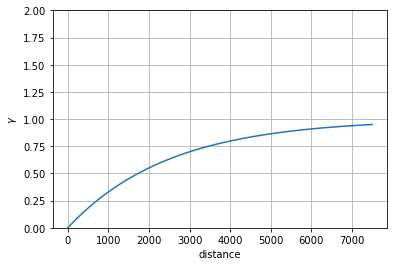

In [8]:
v = pyemu.geostats.ExpVario(contribution=1.0,a=2500.0)
gs = pyemu.geostats.GeoStruct(variograms=v,nugget=0.0)
ax = gs.plot()
ax.grid()
ax.set_ylim(0,2.0);

Now we need to know where the pilot points are.  We can get this from the pilot point template file:

In [9]:
# make a dataframe called df_pp using pyemu helper and the pilot point template file hkpp.dat.tpl
df_pp = pyemu.pp_utils.pp_tpl_to_dataframe(os.path.join(tmp_d,"hkpp.dat.tpl"))

Now let's build a covariance matrix from the geostatistical structure

In [10]:
# define a covariance matrix called cov using pyemu's geostatistics capabilities
cov = gs.covariance_matrix(df_pp.x,df_pp.y,df_pp.parnme)

In [11]:
# use the pyemu helper to construct preferred difference regularization equations 
# using the covariance for regularization weight
pyemu.helpers.first_order_pearson_tikhonov(pst,cov)

getting CC matrix
processing


In [12]:
# print the new regularization equations out
pst.prior_information

,pilbl,equation,obgnme,weight
pilbl,,,,
pcc_66,pcc_66,1.0 * log(hk_i:2_j:2_zone:1.0) - 1.0 * log(hk_i:2_j:7_zone:1.0) = 0.0,regul_cc,0.606531
pcc_67,pcc_67,1.0 * log(hk_i:2_j:2_zone:1.0) - 1.0 * log(hk_i:2_j:12_zone:1.0) = 0.0,regul_cc,0.367879
pcc_68,pcc_68,1.0 * log(hk_i:2_j:2_zone:1.0) - 1.0 * log(hk_i:2_j:17_zone:1.0) = 0.0,regul_cc,0.223130
pcc_69,pcc_69,1.0 * log(hk_i:2_j:2_zone:1.0) - 1.0 * log(hk_i:7_j:2_zone:1.0) = 0.0,regul_cc,0.606531
pcc_70,pcc_70,1.0 * log(hk_i:2_j:2_zone:1.0) - 1.0 * log(hk_i:7_j:7_zone:1.0) = 0.0,regul_cc,0.493069
...,...,...,...,...
pcc_467,pcc_467,1.0 * log(hk_i:32_j:17_zone:1.0) - 1.0 * log(hk_i:37_j:12_zone:1.0) = 0.0,regul_cc,0.493069
pcc_468,pcc_468,1.0 * log(hk_i:32_j:17_zone:1.0) - 1.0 * log(hk_i:37_j:17_zone:1.0) = 0.0,regul_cc,0.606531
pcc_469,pcc_469,1.0 * log(hk_i:37_j:7_zone:1.0) - 1.0 * log(hk_i:37_j:12_zone:1.0) = 0.0,regul_cc,0.606531


What happened?  

We replace the preferred value equations with a bunch of new equations.  These equations each include two parameter names and have different weights - can you guess what the weights are?  The weights are the pearson correlation coefficients (CC) between the pilot points (remember those from way back?).  These CC values are calculated from the covariance matrix, which is implied by the geostatistical structure...whew! For example, ``hk00`` is "close" to ``hk01``, so they have a high CC value (equation 1).  Just for fun, go back and change the "a" parameter in the variogram and see how it changes the CC values.

> Handy hint:  you can use both preferred value and preferred difference regularization in the same PEST control file, and even on the same parameter!

Tikhonov regularization is a go-to tool, and we'll dedicate an entire notebook to applying Tikhonov to our overfit pilot point calibration.  But, before we go let's think of regularization in the broadest context....

Recall that regularization refers to any approach that makes an illposed/underdetermined parameter estimation problem solvable.  

Therefore, when you manually reduce the number of parameters such as zones you are doing a type of regularization.  

